In [41]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.fftpack import fftn, ifftn

### Configuration options

In [45]:
rotatedFrame = True
hills = False
canyon = True

plotting = True

exp_names = {
    'rotatedFrame': ['unrotated', 'rotated'],
    'canyon': ['', '_canyon'],
    'hills': ['', '_hills'],
}

experiment_path = "../../MITgcm/experiments/"
experiment_name = (
    exp_names['rotatedFrame'][rotatedFrame] +
    exp_names['hills'][hills] +
    exp_names['canyon'][canyon]
)
input_path = experiment_path + experiment_name + '/input/'
input_path

'../../MITgcm/experiments/rotated_canyon/input/'

### Physical parameters

In [52]:
# environmental parameters
N = 1.3e-3
f = 0.53e-4

gravity = 9.81
tAlpha = 2.e-4

# grid param
nx = 128
ny = 128
nz = 300

dx = 300 
dy = 300
dz0 = 4
nz_vary_frac = 0.65

Lx = nx*dx
Ly = ny*dy

# topographic parameters
slopeAngle = 2.e-3
hill_height = 20.
hill_length = Lx/3
canyon_width = 5.e3
canyon_depth = 300.

# mixing parameters
d = 230
k0 = 5.2e-5
k1 = 1.8e-3

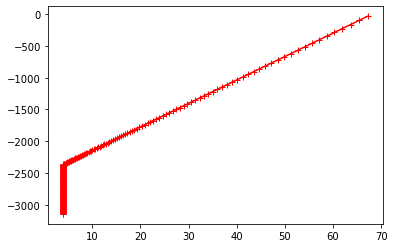

In [53]:
nz_vary = np.int(nz*nz_vary_frac)
dz = dz0 * np.ones((nz))[:,np.newaxis,np.newaxis]*np.ones((nz,ny,nx))
dz[nz_vary:,:,:] = dz[nz_vary,0,0]*1.0275**np.arange(0,nz-nz_vary,1.0)[:,np.newaxis,np.newaxis]*np.ones((nz-nz_vary,ny,nx))
Hz = sum(dz[:,0,0])

x = np.arange(dx/2.0,Lx,dx)[np.newaxis,np.newaxis,:]*np.ones((nz,ny,nx))
y = np.arange(dy/2.0,Ly,dy)[np.newaxis,:,np.newaxis]*np.ones((nz,ny,nx))
z = (-Hz + np.cumsum(dz,axis=0) - dz/2.0)

if plotting:
    plt.figure()
    plt.plot(dz[:,0,0],z[:,0,0],"r-+")


Slope angle is: 0.002


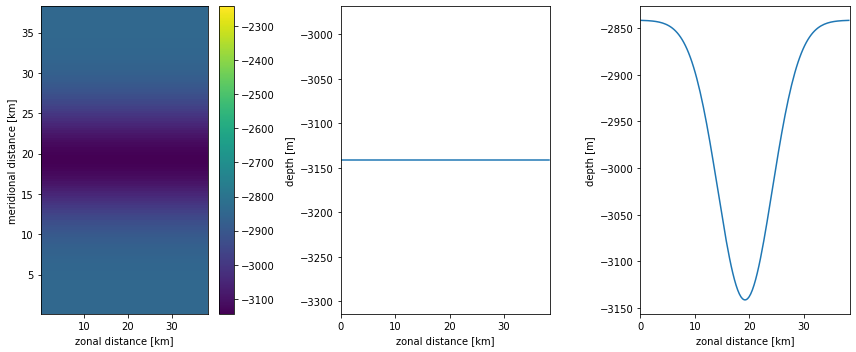

In [54]:
# Create topography
if rotatedFrame: mean_slope = 0.
else: mean_slope = np.tan(slopeAngle)

print("Slope angle is: "+np.str(slopeAngle))

Hbot = np.zeros_like(x)
Hbot[0,:,:] = x[0,:,:]*mean_slope

if hills: Hbot += hill_height*(1. + np.sin(2*np.pi*x/hill_length))
if canyon: Hbot += canyon_depth*(1. - np.exp( -(y-Ly/2)**2 / (2*canyon_width**2)))
    
Hbot = Hbot - (Hz - dz0)
if not(rotatedFrame): Hbot[:,:,0] = 0; Hbot[:,:,-1] = 0;

# Add perturbation to bottom
#Hbot += np.random.rand(ny,nx)[np.newaxis,:,:]*1.e-5

if plotting:
    plt.figure(figsize=(12,5))
    plt.subplot(1,3,1)
    plt.pcolor(x[0,:,:]*1e-3,y[0,:,:]*1e-3,Hbot[0,:,:])
    plt.xlabel('zonal distance [km]')
    plt.ylabel('meridional distance [km]')
    plt.colorbar()
    plt.clim([np.min(z),np.min(z)+900])

    plt.subplot(1,3,2)
    plt.plot(x[0,0,:]*1e-3,Hbot[0,ny//2,:])
    plt.xlim([0,nx*dx*1e-3])
    plt.xlabel('zonal distance [km]')
    plt.ylabel('depth [m]')

    plt.subplot(1,3,3)
    plt.plot(y[0,:,0]*1e-3,Hbot[0,:,nx//2])
    plt.xlim([0,ny*dy*1e-3])
    plt.xlabel('zonal distance [km]')
    plt.ylabel('depth [m]')
    
    plt.tight_layout()
    plt.show()



Temperature Lapse Rate is: 0.0008613659531090722


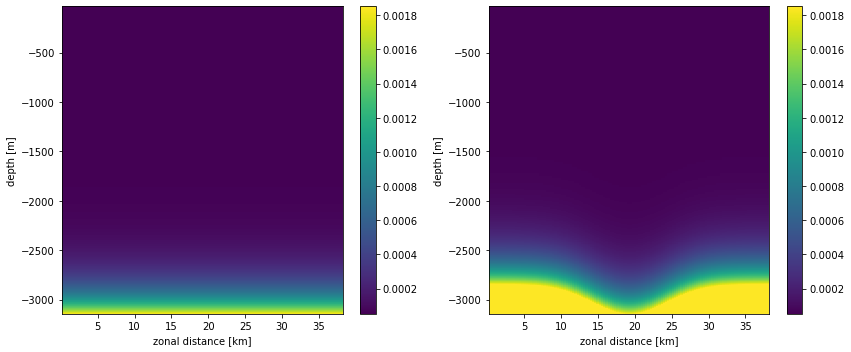

In [57]:
gamma = (N**2)/(gravity*tAlpha)
gamma_eps = gamma*1.e-4

U = np.zeros((nz,ny,nx))
V = np.zeros((nz,ny,nx))
if not(rotatedFrame): T = gamma * (z+Hz);
else: T = np.zeros((nz,ny,nx))

print("Temperature Lapse Rate is: "+np.str((N**2)/(gravity*tAlpha)))

# generate 3D vertical eddy diffusivity field
K = np.zeros((nz,ny,nx))
for i in range(nx):
    for j in range(ny):
        K[:, j, i] = k0 + k1*np.exp(-(z[:,0,0] - Hbot[0,j,i])/d)
K[K>(k1+k0)] = k1+k0

if plotting:
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.pcolor(x[:,0,:]*1e-3,z[:,0,:],K[:,nx//2,:])
    plt.xlabel('zonal distance [km]')
    plt.ylabel('depth [m]')
    plt.colorbar()
    
    plt.subplot(1,2,2)
    plt.pcolor(y[:,:,0]*1e-3,z[:,:,0],K[:,:,ny//2])
    plt.xlabel('zonal distance [km]')
    plt.ylabel('depth [m]')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

In [35]:
# Reverse vertical axis so first index is at the surface and transpose axes
U = U[::-1,:,:]
V = V[::-1,:,:]
T = T[::-1,:,:]
K = K[::-1,:,:]
dz = dz[::-1,:1,:1]

# save input data as binary files
newFile = open(input_path+"U.init", "wb")
newFile.write(bytes(U.astype('>f8')))
newFile.close()

newFile = open(input_path+"V.init", "wb")
newFile.write(bytes(V.astype('>f8')))
newFile.close()

newFile = open(input_path+"T.init", "wb")
newFile.write(bytes(T.astype('>f8')))
newFile.close()

newFile = open(input_path+"kappa.init", "wb")
newFile.write(bytes(K.astype('>f8')))
newFile.close()

newFile = open(input_path+"topog.init", "wb")
newFile.write(bytes(Hbot[0,:,:].astype('>f8')))
newFile.close()

newFile = open(input_path+"delZ.init", "wb")
newFile.write(bytes(dz[:,0,0].astype('>f8')))
newFile.close()

In [36]:
import os
os.system(f"cp ./gendata.ipynb {input_path}");